In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ocean-modelC/Data/final_myPersonality.csv')

In [ ]:
df.head()

,Unnamed: 0,STATUS,cEXT,cNEU,cAGR,cCON,cOPN
0,0,likes sound thunder.,0,1,0,0,1
1,1,sleepy even funny get sleep.,0,1,0,0,1
2,2,sore wants knot muscles base neck stop hurting...,0,1,0,0,1
3,3,likes day sounds new song.,0,1,0,0,1
4,4,home. happy face smiley,0,1,0,0,1


In [ ]:
df.columns

Index(['Unnamed: 0', 'STATUS', 'cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'], dtype='object')

In [ ]:
df['cOPN'].value_counts()

1    7360
0    2544
Name: cOPN, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


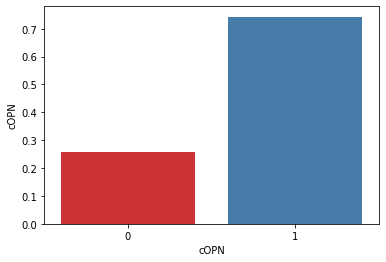

In [ ]:
import seaborn as sns

sns.barplot(df['cOPN'], df['cOPN'], palette='Set1', estimator=lambda x: len(x) / len(df) )

In [ ]:
df['cOPN'] = df['cOPN'].astype('category')

In [ ]:
columns = ['STATUS', 'cOPN']
dataframe = df[columns]
dataframe.head()

,STATUS,cOPN
0,likes sound thunder.,1
1,sleepy even funny get sleep.,1
2,sore wants knot muscles base neck stop hurting...,1
3,likes day sounds new song.,1
4,home. happy face smiley,1


In [ ]:
val_dataframe = dataframe.sample(frac=0.1, random_state=1347)
train_dataframe = dataframe.drop(val_dataframe.index)
val_data, val_labels = val_dataframe['STATUS'], val_dataframe['cOPN']
train_data, train_labels = train_dataframe['STATUS'], train_dataframe['cOPN']
print("Using %d samples for training and %d for validation"% (len(train_dataframe), len(val_dataframe)))

Using 8914 samples for training and 990 for validation


In [ ]:
class_names = ['n', 'y']

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re
import string
  
vectorizer = TextVectorization(standardize = "lower_and_strip_punctuation",
                               max_tokens = 20000, 
                               output_sequence_length = 300,
                               output_mode='int')

train_ds = tf.data.Dataset.from_tensor_slices(train_data).batch(64)
vectorizer.adapt(train_ds)

In [ ]:
vectorizer.get_vocabulary()[0:20]

['',
 '[UNK]',
 'propname',
 'happy',
 'face',
 'smiley',
 'going',
 'day',
 'like',
 'get',
 'one',
 'time',
 'go',
 'new',
 'back',
 'today',
 'work',
 'got',
 'good',
 'big']

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
!unzip "/content/drive/MyDrive/ocean-modelC/Data/glove.6B.zip" -d '/content/drive/MyDrive/ocean-modelC/Data'

Archive:  /content/drive/MyDrive/ocean-modelC/Data/glove.6B.zip
replace /content/drive/MyDrive/ocean-modelC/Data/glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/ocean-modelC/Data/glove.6B.50d.txt  
  inflating: /content/drive/MyDrive/ocean-modelC/Data/glove.6B.100d.txt  
  inflating: /content/drive/MyDrive/ocean-modelC/Data/glove.6B.200d.txt  
  inflating: /content/drive/MyDrive/ocean-modelC/Data/glove.6B.300d.txt  


In [ ]:
import os 
path_to_glove_file = '/content/drive/MyDrive/ocean-modelC/Data/glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 12336 words (3901 misses)


In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable = False,
)

In [ ]:
from tensorflow.keras import layers
xavier =  tf.keras.initializers.GlorotNormal()

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.LSTM(64, dropout = 0.25))(embedded_sequences)
x = layers.Dense(8, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

predictions = layers.Dense(2, activation="softmax", name="predictions")(x)
model = tf.keras.Model(int_sequences_input, predictions)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 100)         1623900   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1032      
_________________________________________________________________
batch_normalization_4 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 18  

In [ ]:
X_train = vectorizer(np.array([[s] for s in train_data])).numpy()
X_val = vectorizer(np.array([[s] for s in val_data])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [ ]:
from sklearn.utils import compute_class_weight

classWeight = compute_class_weight('balanced', [0,1], df['cOPN']) 
classWeight = dict(enumerate(classWeight))
print(classWeight)

{0: 1.9465408805031446, 1: 0.6728260869565217}


In [ ]:
rms = tf.keras.optimizers.RMSprop(learning_rate=4*1e-5, rho=0.9, momentum=0.2, epsilon=1e-07)

model.compile(loss = "sparse_categorical_crossentropy", optimizer = rms, metrics = ["acc"])

history = model.fit(X_train, y_train, batch_size = 128, epochs = 35, validation_data = (X_val, y_val), class_weight=classWeight)

Epoch 1/35
70/70 [==============================] - 6s 47ms/step - loss: 0.9972 - acc: 0.5084 - val_loss: 0.7209 - val_acc: 0.4172
Epoch 2/35
70/70 [==============================] - 3s 36ms/step - loss: 0.9537 - acc: 0.5240 - val_loss: 0.6933 - val_acc: 0.5545
Epoch 3/35
70/70 [==============================] - 2s 36ms/step - loss: 0.8887 - acc: 0.5293 - val_loss: 0.6810 - val_acc: 0.5949
Epoch 4/35
70/70 [==============================] - 3s 36ms/step - loss: 0.8790 - acc: 0.5495 - val_loss: 0.6508 - val_acc: 0.6919
Epoch 5/35
70/70 [==============================] - 3s 36ms/step - loss: 0.7778 - acc: 0.5639 - val_loss: 0.6583 - val_acc: 0.6768
Epoch 6/35
70/70 [==============================] - 3s 36ms/step - loss: 0.7455 - acc: 0.5506 - val_loss: 0.6703 - val_acc: 0.6192
Epoch 7/35
70/70 [==============================] - 3s 36ms/step - loss: 0.7329 - acc: 0.5483 - val_loss: 0.6805 - val_acc: 0.5798
Epoch 8/35
70/70 [==============================] - 3s 36ms/step - loss: 0.7263 - a

In [ ]:
score, acc = model.evaluate(x=(X_val), y=(y_val), batch_size = 128)
print('Test score:', score)
print('Test accuracy:', acc)

8/8 [==============================] - 0s 26ms/step - loss: 0.6751 - acc: 0.5909
Test score: 0.6751164197921753
Test accuracy: 0.5909090638160706


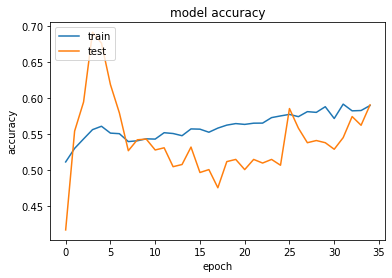

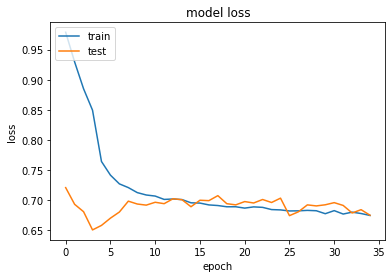

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred))

Confusion Matrix
[[130 126]
 [279 455]]


In [ ]:
print('Classification Report')
target_names = class_names
print(classification_report(y_val, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           n       0.32      0.51      0.39       256
           y       0.78      0.62      0.69       734

    accuracy                           0.59       990
   macro avg       0.55      0.56      0.54       990
weighted avg       0.66      0.59      0.61       990



In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

In [ ]:
rms = tf.keras.optimizers.RMSprop(learning_rate=4*1e-5, rho=0.9, momentum=0.2, epsilon=1e-07)
end_to_end_model.compile(loss = "sparse_categorical_crossentropy", optimizer = rms, metrics = ["acc"])

In [ ]:
probabilities = end_to_end_model.predict(
    [["I  love new experiences"]]
)

class_names[np.argmax(probabilities[0])]

'y'

In [ ]:
end_to_end_model.save('/content/drive/MyDrive/ocean-modelC/Models/OModel', save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ocean-modelC/Models/OModel_58_59/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ocean-modelC/Models/OModel_58_59/assets


In [ ]:
Omodel = keras.models.load_model('/content/drive/MyDrive/ocean-modelC/Models/OModel')

In [ ]:
print(class_names[np.argmax(Omodel.predict([['I like new experiences']]))])

y
